<a href="https://colab.research.google.com/github/SravaniKarri137/Stroke-Identification-A-Machine-Learning-Based-Diagnostic-Model-Using-Neuroimages/blob/main/ML_Project4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Accuracy after training: 0.9620758483033932
Classification Report:
              precision    recall  f1-score   support

      normal       0.95      0.99      0.97       305
      stroke       0.98      0.92      0.95       196

    accuracy                           0.96       501
   macro avg       0.97      0.96      0.96       501
weighted avg       0.96      0.96      0.96       501



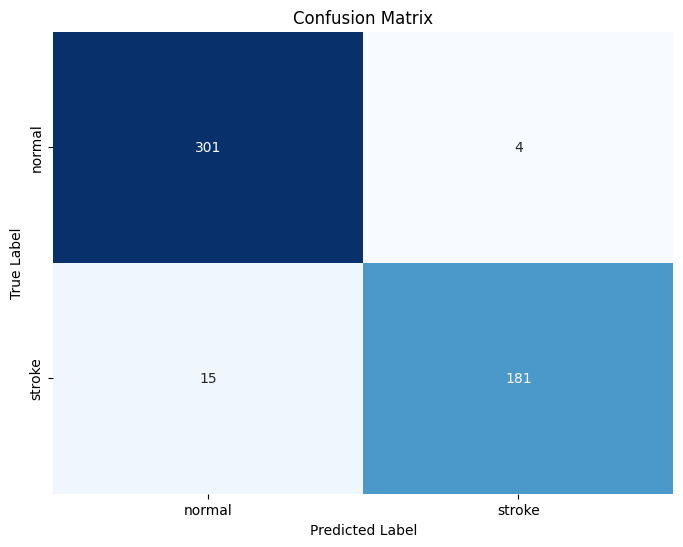

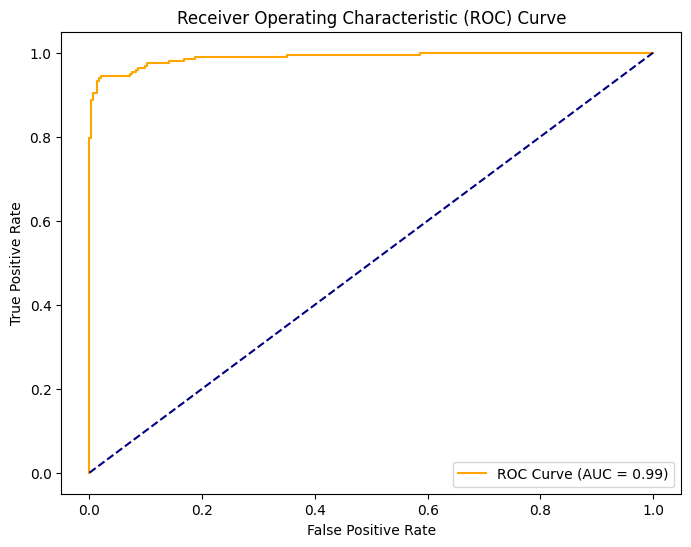

Cross-Validation Accuracy: 0.6389341317365269
Error: [Errno 2] No such file or directory: "'/content/drive/MyDrive/Brain_Data_Organised/Stroke/58 (18).jpg'"
Error: [Errno 2] No such file or directory: "'/content/drive/MyDrive/Brain_Data_Organised/Stroke/58 (10).jpg'"
Enter the path to the image (or 'exit' to quit): /content/drive/MyDrive/Brain_Data_Organised/Stroke/58 (10).jpg
Prediction: stroke


In [ ]:
from skimage.feature import hog, local_binary_pattern
from skimage.filters import gabor
import numpy as np
import os
from PIL import Image
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = Image.open(os.path.join(folder, filename))
        if img is not None:
            images.append(img)  # Keep images as PIL Image objects
    return images

def preprocess_image(img, target_size=(100, 100)):
    img = img.convert('L')  # Convert to grayscale
    img = img.resize(target_size)  # Resize image
    return np.array(img)

def extract_features_parallel(images):
    num_processes = multiprocessing.cpu_count()
    with multiprocessing.Pool(processes=num_processes) as pool:
        features = pool.map(extract_features_single, images)
    return features

def extract_features_single(img):
    # HOG features
    hog_feat = hog(img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1))
    # LBP features
    lbp_feat = local_binary_pattern(img, 8, 1, method='uniform').ravel()
    # Gabor filter features
    gabor_feat = np.array([np.mean(gabor(img, frequency=freq)[0]) for freq in [0.1, 0.5, 1.0]])

    # Concatenate features
    combined_feat = np.concatenate((hog_feat, lbp_feat, gabor_feat))
    return combined_feat

# Load images
normal_images = load_images_from_folder('/content/drive/MyDrive/Brain_Data_Organised/Normal')
stroke_images = load_images_from_folder('/content/drive/MyDrive/Brain_Data_Organised/Stroke')

# Preprocess images
normal_images_processed = [preprocess_image(img) for img in normal_images]
stroke_images_processed = [preprocess_image(img) for img in stroke_images]

# Extract features
normal_features = extract_features_parallel(normal_images_processed)
stroke_features = extract_features_parallel(stroke_images_processed)

# Combine features and labels
X = normal_features + stroke_features
y = ['normal'] * len(normal_features) + ['stroke'] * len(stroke_features)

# Encode labels to binary format
label_encoder = LabelEncoder()
y_binary = label_encoder.fit_transform(y)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_binary, test_size=0.2, random_state=42)

# Train SVM classifier
svm = SVC(kernel='linear', probability=True)
svm.fit(X_train, y_train)

# Evaluate performance on test set
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy after training:", accuracy)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", cbar=False,
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# ROC curve
y_prob = svm.predict_proba(X_test)[:, 1]  # Probability of positive class
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', label='ROC Curve (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Cross-validation
cv_scores = cross_val_score(svm, X_scaled, y_binary, cv=5)
print("Cross-Validation Accuracy:", cv_scores.mean())

# User input prediction
while True:
    image_path = input("Enter the path to the image (or 'exit' to quit): ")
    if image_path.lower() == 'exit':
        break
    try:
        # Preprocess image
        img = Image.open(image_path)
        img = preprocess_image(img)

        # Extract features
        features = extract_features_single(img)
        features_scaled = scaler.transform([features])

        # Make prediction
        prediction = svm.predict(features_scaled)
        print("Prediction:", label_encoder.inverse_transform(prediction)[0])
    except Exception as e:
        print("Error:", e)
